In [145]:
%matplotlib inline

# Laden der verwendeten Bibliotheken
import   numpy  as np   
import   matplotlib                 # https://matplotlib.org/3.1.1/tutorials/index.html
import   matplotlib.pyplot as plt   # https://matplotlib.org/tutorials/introductory/pyplot.html
import cv2

In [146]:
def imshow(img):
    shape=img.shape
    plt.figure(figsize = (10,10))
    if(len(shape)==2):
        plt.imshow(img,cmap='gray')
    else:
        plt.imshow(img[:,:,::-1])
    plt.axis(False)
    plt.show()   

In [147]:
def fullContrast(img):
    min=np.min(img)
    max=np.max(img)
    return (img-min).astype(float)/(max-min)

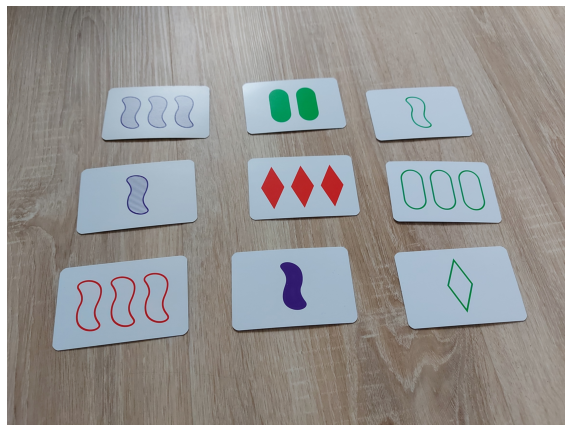

In [148]:
# Bild laden mit OpenCV
img = cv2.imread("set/set4.jpg")
imshow(img)

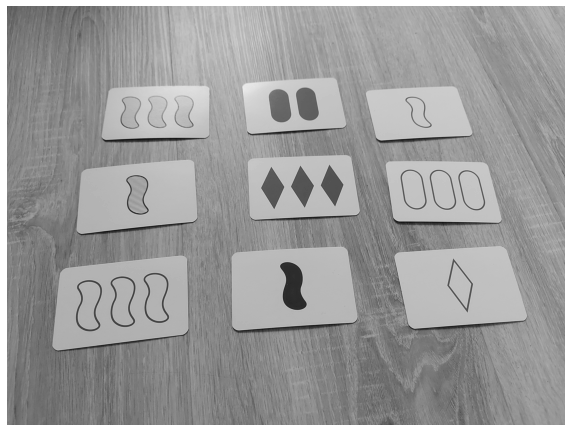

In [149]:
gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
imshow(gray)

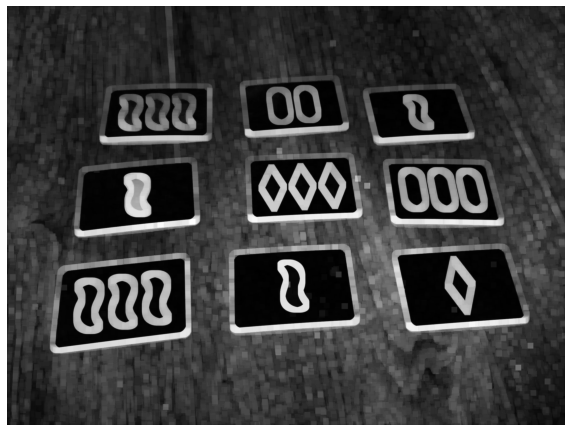

In [150]:
morphgradient=cv2.dilate(gray,np.ones((23,23)))-cv2.erode(gray,np.ones((23,23)))
imshow(morphgradient)

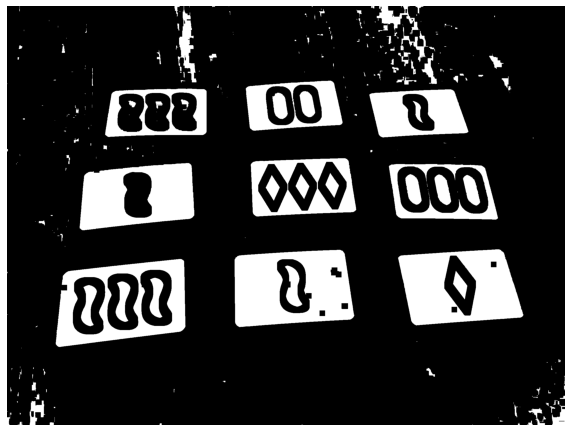

In [151]:
regions=(morphgradient<20).astype(np.uint8)
imshow(fullContrast(regions))

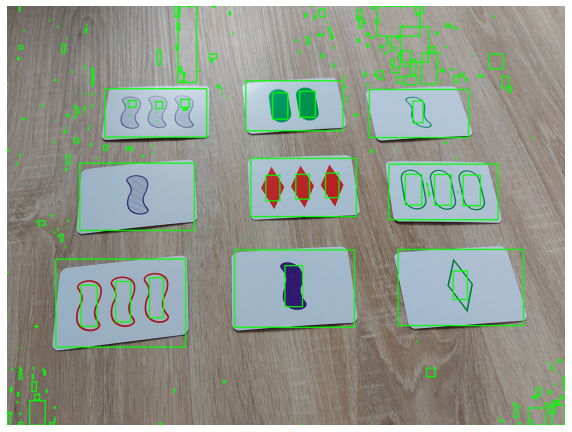

In [152]:
(numLabels, labels, stats, centroids) = cv2.connectedComponentsWithStats(regions, 4, cv2.CV_32S)
boundingboxview=img.copy()
for i in range(1, numLabels):
    x = stats[i, cv2.CC_STAT_LEFT]
    y = stats[i, cv2.CC_STAT_TOP]
    w = stats[i, cv2.CC_STAT_WIDTH]
    h = stats[i, cv2.CC_STAT_HEIGHT]
    area = stats[i, cv2.CC_STAT_AREA]
    (cX, cY) = centroids[i]
    cv2.rectangle(boundingboxview,(x,y),(x+w,y+h),(0,255,0),3)
    mask=(labels==i).astype(np.uint8)
imshow(boundingboxview)

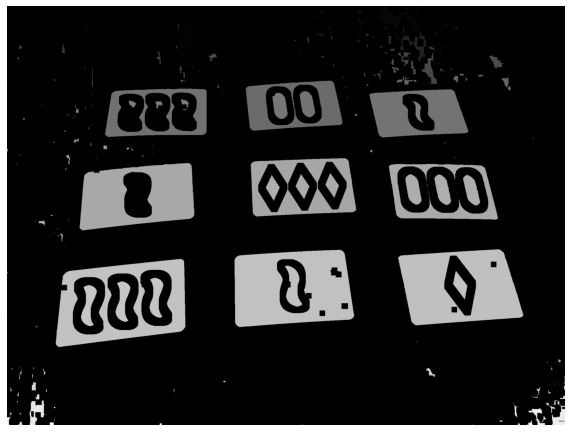

In [153]:
imshow(labels)

In [154]:
# Extrahieren aller äußeren Konturen als Liste von Pixelketten
contours,_ = cv2.findContours(regions,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
print(len(contours))

278


In [155]:
contour=contours[62]
print(contour.shape)
print(contour)

(10, 1, 2)
[[[2235 1474]]

 [[2236 1474]]

 [[2237 1474]]

 [[2238 1475]]

 [[2239 1475]]

 [[2240 1474]]

 [[2239 1474]]

 [[2238 1474]]

 [[2237 1474]]

 [[2236 1474]]]


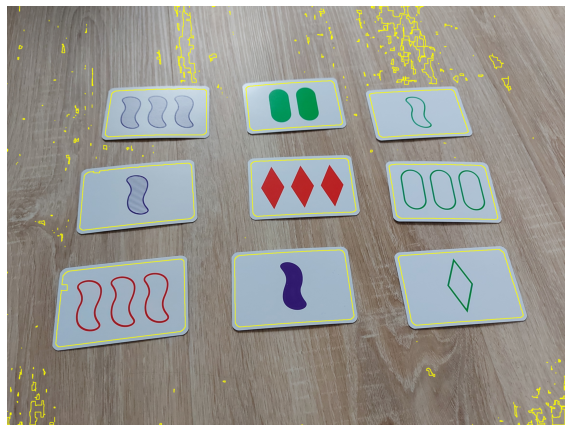

In [156]:
annotated=img.copy()

for contour in contours: 
    cv2.drawContours(annotated, [contour], 0, (0,255,255), 2)
    
imshow(annotated)

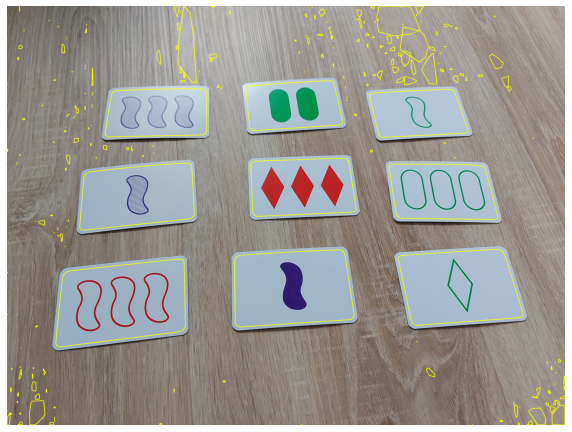

In [157]:
annotated=img.copy()

for contour in contours:
    
    convex=cv2.convexHull(contour) 

    cv2.drawContours(annotated, [convex], 0, (0,255,255), 2)

imshow(annotated)

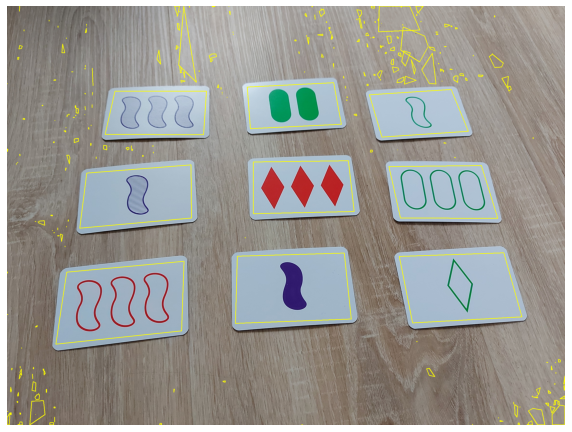

In [158]:
annotated=img.copy()

for contour in contours:
    convex=cv2.convexHull(contour) 

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    cv2.drawContours(annotated, [approx], 0, (0,255,255), 2)
imshow(annotated)

In [159]:
# Liste zum Speichern der Rechtecke zu den gefundenen Karten
card_quadrangles=[]


for contour in contours:

    convex=cv2.convexHull(contour) # Konvexe Hülle bilden

    arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
    
    approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen

    if(len(approx)!=4): # Viereckstest
        continue
        
    # Alle vier Kantenlängen ermitteln. "cv2.norm" berechnet per Default die L2-Norm, also den Euklidischen Abstand
    l0=cv2.norm(approx[0],approx[1]) 
    l1=cv2.norm(approx[1],approx[2])
    l2=cv2.norm(approx[2],approx[3])
    l3=cv2.norm(approx[3],approx[0])
    
    # Mittlere Breite und Höhe bestimmen (Annahme: Parallelogramm)
    w,h = (l0+l2)/2, (l1+l3)/2
    
    if(abs(l0-l2)>0.15*w) | (abs(l1-l3)>0.15*h): # Parallelogrammtest
        continue
    
    # Wenn Breite>Höhe: um 90° drehen (eine Karte ist höher als breit)
    if(w>h):
        w,h = h,w
        approx=np.roll(approx,1,axis=0)

    if(w  <100) | (h > 600): # Größentest
        continue

    if(h > 2.2*w) | (h<1.2 * w):   # Seitenverhältnistest
        continue

    card_quadrangles.append(np.squeeze(approx))

print(len(card_quadrangles))

9


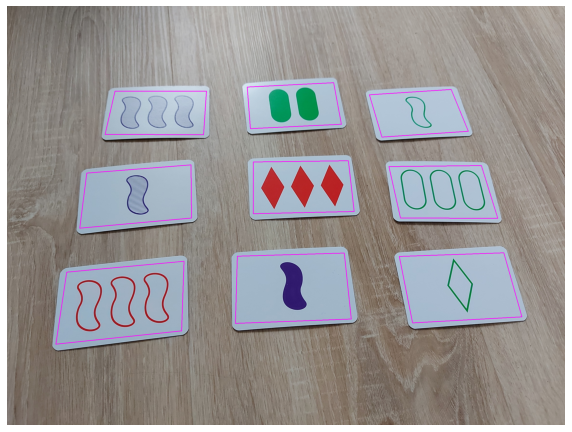

In [160]:
annotated=img.copy()
for quad in card_quadrangles:
    cv2.drawContours(annotated, [quad], 0, (255,0,255), 2)
imshow(annotated)

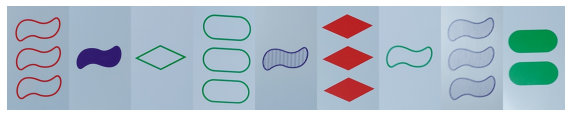

In [167]:
result = None

cards = []

for card in card_quadrangles:
    
    destRect = np.float32([[0,0],[300,0],[300,500],[0,500]])

    transformMatrix = cv2.getPerspectiveTransform(card.astype(np.float32), destRect)

    cardImage = cv2.warpPerspective(img,transformMatrix,(300,500))
    
    cards.append(cardImage)
    
    if result is None:
        result=cardImage.copy()
    else:
        result=np.concatenate([result,cardImage],axis=1)   

imshow(result)

In [169]:
answer = np.array([])

for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    morphgradient = cv2.dilate(gray,np.ones((5,5)))-cv2.erode(gray,np.ones((5,5)))
    regions=(morphgradient<20).astype(np.uint8)
    
    # Find contours
    contours, _ = cv2.findContours(regions, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    object_count = 0
    objectAreaArr = np.array([])
    
    # Loop over contours and filter for diamond shape
    for contour in contours:
        convex=cv2.convexHull(contour) # Konvexe Hülle bilden
        arcLength=cv2.arcLength(convex,True) # Konturlänge ermitteln
        approx=cv2.approxPolyDP(convex,0.05*arcLength,True) # Kontur zu Polygonzug vereinfachen
        
        # if(len(approx)<4): # Viereckstest
        #     continue

        area = cv2.contourArea(contour)
        # print(area)

        if area > 16000 and area < 148000:  
            objectAreaArr = np.insert(objectAreaArr, len(objectAreaArr), area)
            # cv2.drawContours(cardImage, [contour], 0, (0, 255, 0), 2)

        result = np.array([])
        
        for area in objectAreaArr:
            if area >= np.max(objectAreaArr)*0.9:
                result = np.insert(result, len(result) ,area)
                
    answer = np.insert(answer, len(answer), len(result))      

    
    # imshow(cardImage)
    # print(len(result))
    # print(result)

print(answer)

[3. 1. 1. 3. 1. 3. 1. 3. 2.]


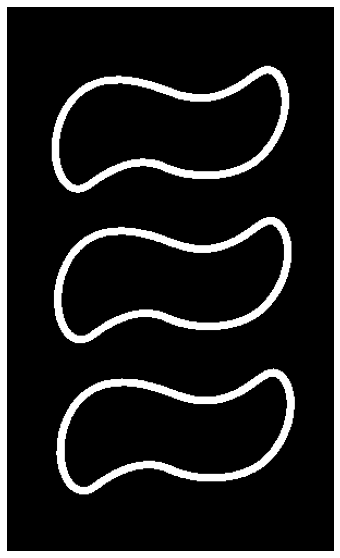

Object is empty
Object is empty
Object is empty


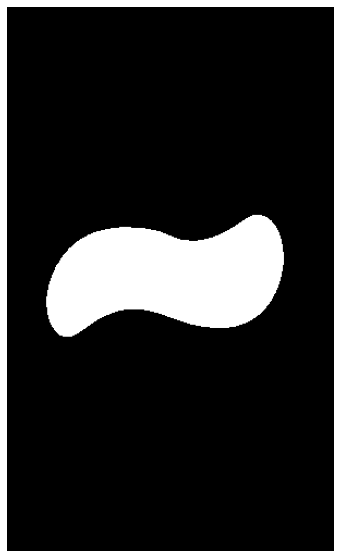

Object is empty


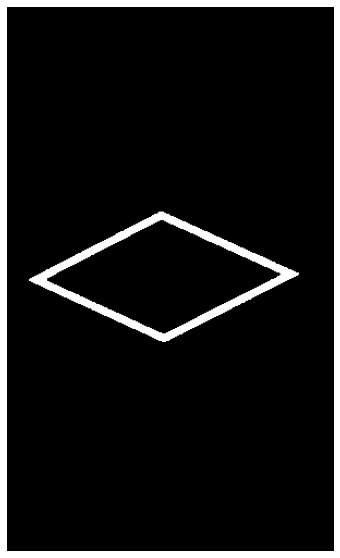

Object is empty


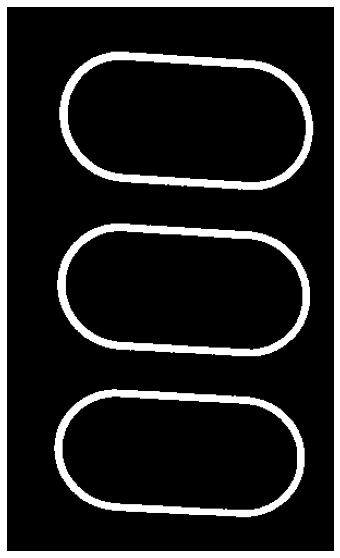

Object is empty
Object is empty
Object is empty


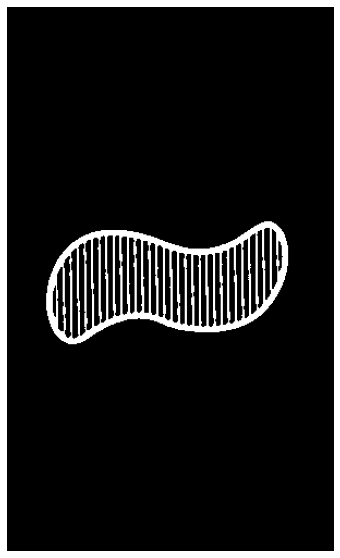

Object is empty


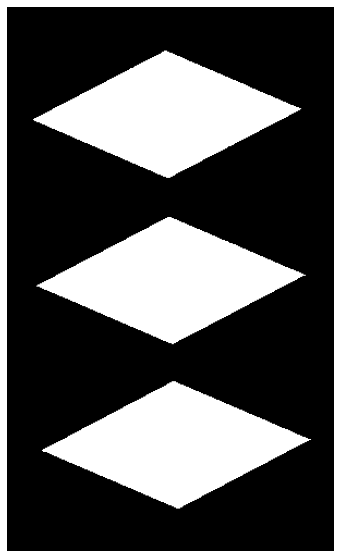

Object is empty
Object is empty
Object is empty


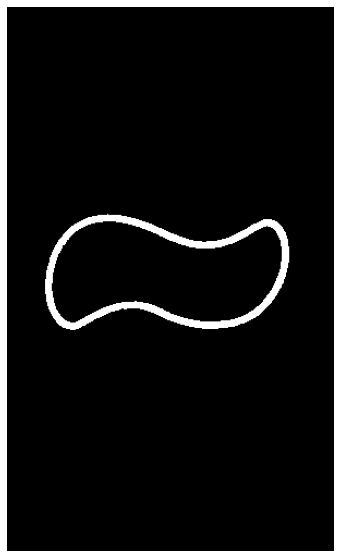

Object is empty


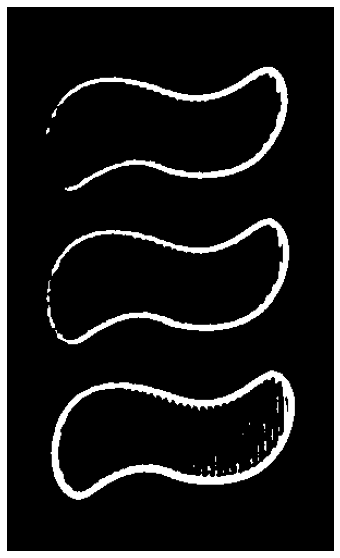

Object is empty
Object is empty
Object is empty
Object is empty
Object is empty
Object is empty
Object is empty
Object is empty


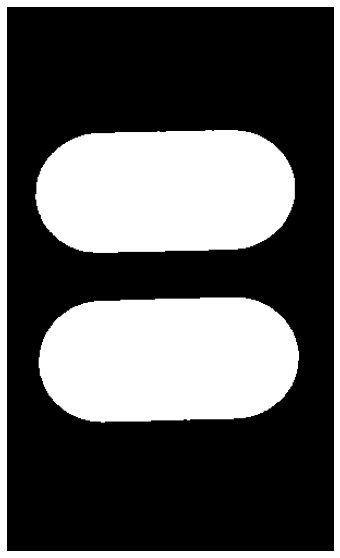

Object is empty
Object is empty


In [174]:
answer = np.array([])

for card in cards:
    # Convert to grayscale
    gray = cv2.cvtColor(card, cv2.COLOR_BGR2GRAY)

    # Threshold the image
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    imshow(thresh)
    
    # Find contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Calculate object properties for each contour
    for contour in contours:
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)
        circularity = 4 * np.pi * area / (perimeter * perimeter)
        if circularity > 0.8:
            print('Object is filled with color')
        else:
            thresh_resized = cv2.resize(thresh, (img.shape[1], img.shape[0]))
            mean_color = cv2.mean(img, mask=thresh_resized)
            if np.std(mean_color) < 30:
                print('Object is striped')
            else:
                print('Object is empty')